In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
root = './Datasets/FashionMNIST'
mnist_train = torchvision.datasets.FashionMNIST(root, train=True, transform=transforms.ToTensor(), download=True)
mnist_test = torchvision.datasets.FashionMNIST(root, train=False, transform=transforms.ToTensor(), download=True)

In [44]:
# 10 classes, each class has 6000 for train and 1000 for test
print(len(mnist_train))
print(len(mnist_test))

60000
10000


In [45]:
print(mnist_train[0][0].shape)  # feature
print(mnist_train[0][1])    # label

torch.Size([1, 28, 28])
9


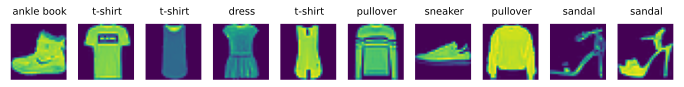

In [46]:
from d2lzh_pytorch import show_fashion_mnist, get_fashion_mnist_labels

# show the first 10 imgs
imgs, labels = [mnist_train[i][0].squeeze() for i in range(10)], [mnist_train[i][1] for i in range(10)]
names = get_fashion_mnist_labels(labels)
show_fashion_mnist(imgs, names)

In [47]:
from d2lzh_pytorch import load_data_fashion_mnist

train_iter, test_iter = load_data_fashion_mnist()
print(train_iter)
print(test_iter)

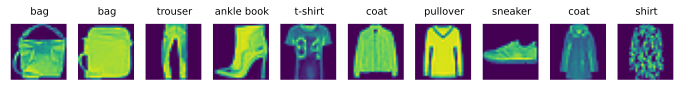

In [48]:
for X, y in train_iter:
    show_fashion_mnist(X[:10].squeeze(), get_fashion_mnist_labels(y))
    break

In [49]:
# Implementing softmax from scratch ( by myself
# X: (batch_size, 28, 28) -> (batch_size, 28*28)
# w: (28*28, 10), b:(1, 10)

#w = torch.randn((28*28, 10), dtype=torch.float)
w = torch.normal(0, 0.01, (28*28, 10))
# with torch.no_grad():
#     w = w * (5/3) / (10 ** 0.5)     # Kaiming distribution
    
b = torch.zeros((1, 10), dtype=torch.float)
lr = 0.1 / 256
num_epoch = 10
lossi = []

parameters = [w, b]
for p in parameters:
    p.requires_grad = True

In [50]:
print(w.requires_grad)
print(b.requires_grad)
print(w.grad_fn)

True
True
None


In [59]:
for i in range(num_epoch):
    for X, y in train_iter:
        logits = X.view(X.shape[0], -1) @ w + b     # (256, 10) ,  b : (1, 10) -broadcast-> (256, 10)
        counts = logits.exp()   # (256, 10)
        probs = counts / counts.sum(1, keepdim=True) # (256, 10) / (256, 1) -> broadcast
        loss = -torch.log(probs[torch.arange(X.shape[0]), y.view(-1)]).mean()
        
        # backward
        for p in parameters:
            p.grad = None
        loss.backward()
        for p in parameters:
            p.data += -lr * p.grad
        
        # track stat
        lossi.append(loss.item())
    
    print(f'epoch {i+1 :5d}  loss {loss.item() : 10f}')
    

epoch     1  loss   0.947818
epoch     2  loss   1.110100
epoch     3  loss   0.964448
epoch     4  loss   1.124783
epoch     5  loss   1.028014
epoch     6  loss   0.927709
epoch     7  loss   0.946096
epoch     8  loss   1.153695
epoch     9  loss   0.959653
epoch    10  loss   0.967639


In [60]:
-torch.log(torch.tensor(1/10))

tensor(2.3026)

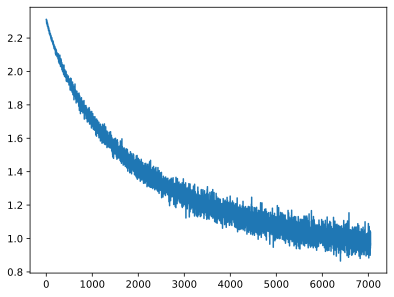

In [61]:
plt.plot(lossi)

In [62]:
acc_sum, n = 0.0, 0
for X, y in test_iter:
    logits = X.view(X.shape[0], -1) @ w + b     # (256, 10) ,  b : (1, 10) -broadcast-> (256, 10)
    counts = logits.exp()   # (256, 10)
    probs = counts / counts.sum(1, keepdim=True) # (256, 10) / (256, 1) -> broadcast
    loss = -torch.log(probs.gather(1, y.view(X.shape[0], 1))).sum()
    acc_sum += loss
    n += y.shape[0]

print(f'loss {acc_sum / n : 10f}')
print(n)

loss   0.984905
10000


torch.Size([10])


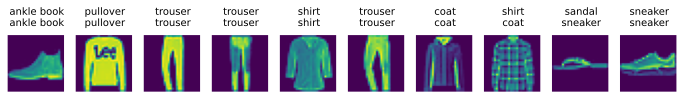

In [63]:
# Predict by trained weights
X, y = iter(test_iter).__next__()
X = X[:10] ; y = y[:10]
names = get_fashion_mnist_labels(y)

logits = X.view(X.shape[0], -1) @ w + b
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
y_hat = probs.argmax(1)
print(y_hat.shape)
name_hat = get_fashion_mnist_labels(y_hat)

titles = []
for n1, n2 in zip(names, name_hat):
    title = n1 + '\n' + n2
    titles.append(title)
    
show_fashion_mnist(X.squeeze(), titles)

In [64]:
# In Pytorch style
from collections import OrderedDict
class FlattenLayer(nn.Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.view(x.shape[0], -1) # (num, -1)
    
class Linear(nn.Module):
    def __init__(self, fan_in, fan_out, bias=True):
        super().__init__()
        self.linear = nn.Linear(fan_in, fan_out, bias)
    
    def forward(self, x):
        out = self.linear(x) # x @ w + b
        return out

net = nn.Sequential(OrderedDict([
    ('flatten', FlattenLayer()),
    ('linear', Linear(28*28, 10))
]))
print(net)

Sequential(
  (flatten): FlattenLayer()
  (linear): Linear(
    (linear): Linear(in_features=784, out_features=10, bias=True)
  )
)


In [81]:
from torch.nn import init

init.normal_(net[1].linear.weight, 0, 0.01)
init.constant_(net[1].linear.bias, 0)

print(net[1].linear.weight.grad_fn)
print(net[1].linear.bias.grad_fn)

None
None


In [83]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

In [85]:
from d2lzh_pytorch import *
num_epochs = 5
loss = nn.CrossEntropyLoss()
train_ch3(net, train_iter, test_iter, loss, num_epochs,
256, None, None, optimizer)

epoch 1, loss 0.0053, train acc 0.634, test acc 0.676
epoch 2, loss 0.0036, train acc 0.714, test acc 0.721
epoch 3, loss 0.0031, train acc 0.749, test acc 0.749
epoch 4, loss 0.0029, train acc 0.767, test acc 0.762
epoch 5, loss 0.0028, train acc 0.780, test acc 0.769


torch.Size([10])


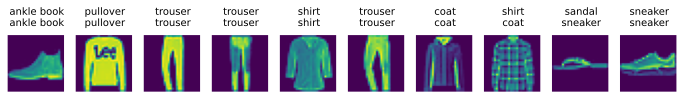

In [86]:
# Predict by trained weights
X, y = iter(test_iter).__next__()
X = X[:10] ; y = y[:10]
names = get_fashion_mnist_labels(y)

logits = X.view(X.shape[0], -1) @ w + b
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
y_hat = probs.argmax(1)
print(y_hat.shape)
name_hat = get_fashion_mnist_labels(y_hat)

titles = []
for n1, n2 in zip(names, name_hat):
    title = n1 + '\n' + n2
    titles.append(title)
    
show_fashion_mnist(X.squeeze(), titles)